In [1]:
import sys
import os
sys.path.append("../core/datasets")
from old_pfdelta_dataset import PFDeltaDataset
import torch
from torch_geometric.datasets import OPFDataset
import pandas 
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import random 
import matplotlib.patches as mpatches
from data_utils import loadcase 
from idx import *

In [3]:
def compute_branch_outage_counts(dataset, edge_to_idx, n_branches):
    """
    edge_to_idx: Dict mapping (from_bus, to_bus) to branch index.
    Assumes only one direction is present in edge_index.
    """
    outage_counts = torch.zeros(n_branches, dtype=torch.int)

    for data in dataset:
        # Extract present edges from the current sample
        edge_index = data['bus', 'branch', 'bus'].edge_index
        present_pairs = set(zip(edge_index[0].tolist(), edge_index[1].tolist()))

        present_indices = set()
        for pair in present_pairs:
            if pair in edge_to_idx:
                present_indices.add(edge_to_idx[pair])

        all_indices = set(range(n_branches))
        outaged_indices = all_indices - present_indices

        for idx in outaged_indices:
            outage_counts[idx] += 1

    return outage_counts

def compute_generator_outage_counts(dataset, n_gens):
    """
    Computes how often each generator is outaged by checking
    which generator indices are *not present* in each sample.
    """
    full_gen_set = set(range(n_gens))
    outage_counts = torch.zeros(n_gens, dtype=torch.int)

    for data in dataset:
        present_gens = set(data['gen', 'gen_link', 'bus'].edge_index[0].tolist())
        outaged_gens = full_gen_set - present_gens
        for gen_id in outaged_gens:
            outage_counts[gen_id] += 1

    return outage_counts

def plot_outage_distribution(outage_counts, title="Outage Frequency", xlabel="Component Index", ylabel="Frequency", label=None):
    plt.figure(figsize=(10, 4))
    indices = range(len(outage_counts))
    plt.bar(indices, outage_counts.tolist(), label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    # Force integer ticks on x-axis
    plt.xticks(indices)
    
    if label:
        plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [4]:
case_path = "pglib/pglib_opf_case14_ieee.m"
case_dict = loadcase(case_path)
edge_to_idx = case_dict["branch"][:, [F_BUS, T_BUS]]
n_branches = edge_to_idx.shape[0]
n_gens = case_dict["gen"].shape[0]
branch_array = case_dict['branch']
edge_to_idx = {}

for idx, (from_bus, to_bus) in enumerate(branch_array[:, :2]):
    i = int(from_bus) 
    j = int(to_bus) 
    edge_to_idx[(i, j)] = idx

root_n = 'my_results/2025-04-28_11-28-43'
dataset_n = PFDeltaDataset(
    root_dir=root_n,
    split='all', 
    case_name="case14_n", # verify path here,
    # topological_perturbations=True, # this has to be added to the class: have it load the correct perturbation?
    force_reload=False
)

root_n_minus_1 = 'my_results/2025-04-28_11-28-43'
dataset_n_minus_1 = PFDeltaDataset(
    root_dir=root_n_minus_1,
    split='all', 
    case_name="case14_n_minus_1", # verify path here,
    # topological_perturbations=True, # this has to be added to the class: have it load the correct perturbation?
    force_reload=False
)

root_n_minus_2 = 'my_results/2025-04-28_11-28-43'
dataset_n_minus_2 = PFDeltaDataset(
    root_dir=root_n_minus_2,
    split='all', 
    case_name="case14_n_minus_2", # verify path here,
    # topological_perturbations=True, # this has to be added to the class: have it load the correct perturbation?
    force_reload=False
)

/Users/anarivera/opt/miniconda3/envs/delta_pf/lib/python3.10/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([BaseStorage])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


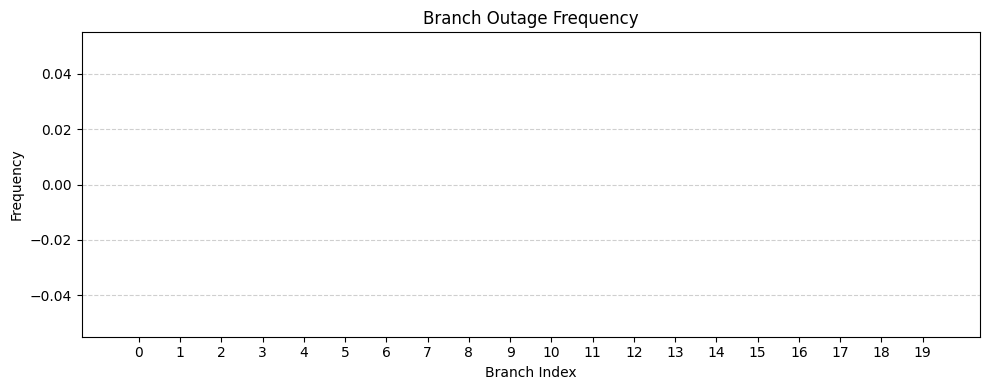

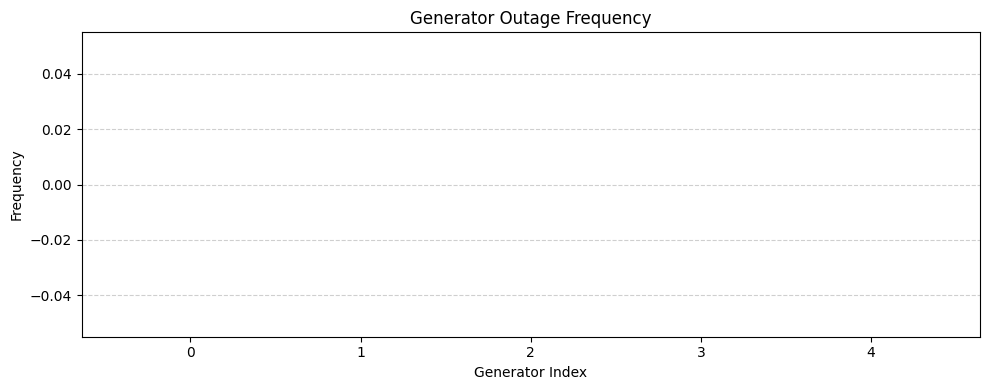

In [6]:
# Check 4.1 Check contingency distributions for n 
outage_counts_branch = compute_branch_outage_counts(dataset_n, edge_to_idx, n_branches)
outage_counts_gen = compute_generator_outage_counts(dataset_n, n_gens)

plot_outage_distribution(
    outage_counts_branch,
    title="Branch Outage Frequency",
    xlabel="Branch Index"
)
plot_outage_distribution(
    outage_counts_gen,
    title="Generator Outage Frequency",
    xlabel="Generator Index"
)

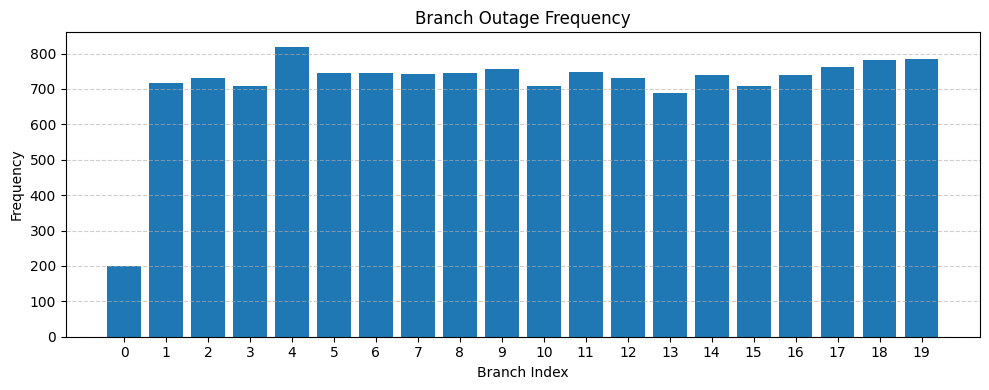

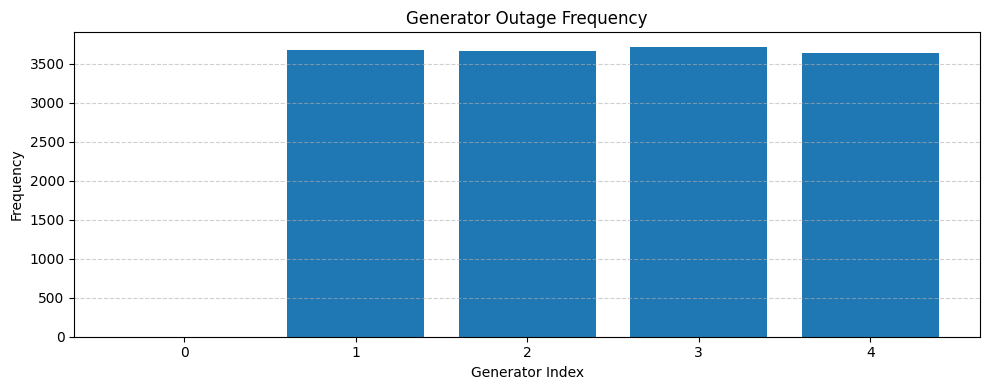

In [7]:
# Check 4.2 Check contingency distributions for n-1
outage_counts_branch = compute_branch_outage_counts(dataset_n_minus_1, edge_to_idx, n_branches)
outage_counts_gen = compute_generator_outage_counts(dataset_n_minus_1, n_gens)

plot_outage_distribution(
    outage_counts_branch,
    title="Branch Outage Frequency",
    xlabel="Branch Index"
)
plot_outage_distribution(
    outage_counts_gen,
    title="Generator Outage Frequency",
    xlabel="Generator Index"
)

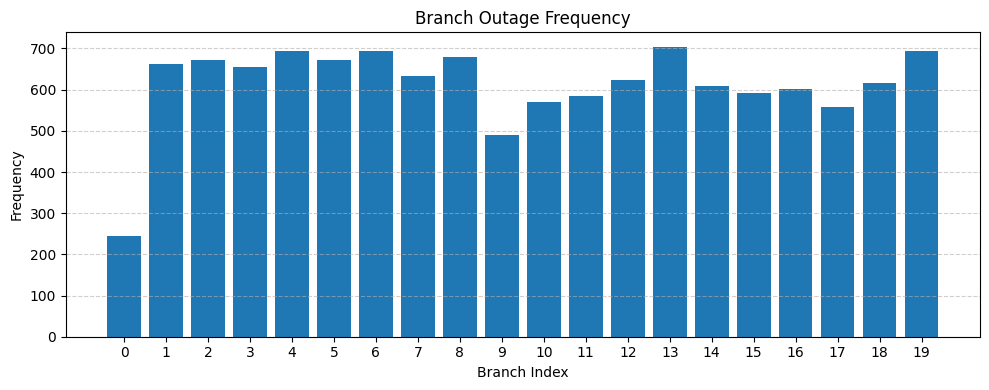

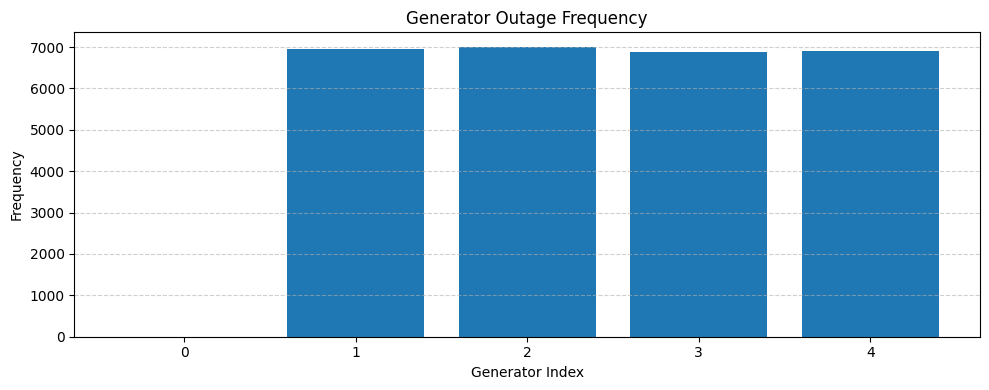

In [8]:
# Check 4.3. Check contingency distributions for n-2
outage_counts_branch = compute_branch_outage_counts(dataset_n_minus_2, edge_to_idx, n_branches)
outage_counts_gen = compute_generator_outage_counts(dataset_n_minus_2, n_gens)

plot_outage_distribution(
    outage_counts_branch,
    title="Branch Outage Frequency",
    xlabel="Branch Index"
)
plot_outage_distribution(
    outage_counts_gen,
    title="Generator Outage Frequency",
    xlabel="Generator Index"
)

In [10]:
def check_power_balance(data):
    """
    Verifies whether a power flow sample satisfies the power flow equations,
    using ground truth values already stored in the `data` object.

    Parameters:
        data (HeteroData): PyG HeteroData graph with:
            - data["bus"].v: voltage magnitude
            - data["bus"].theta: voltage angle
            - data["bus"].pg, data["bus"].qg: generation
            - data["bus"].pd, data["bus"].qd: demand
            - data["bus"].shunt: [g, b]
            - data["bus", "branch", "bus"].edge_index and edge_attr

    Returns:
        torch.Tensor: vector of power mismatch magnitudes (√(ΔP² + ΔQ²))
    """
    V = data["bus"].bus_voltages[:, -1]
    theta = data["bus"].bus_voltages[:, 0]
    pg = data["bus"].bus_gen[:, 0]
    qg = data["bus"].bus_gen[:, -1]
    pd = data["bus"].bus_demand[:, 0]
    qd = data["bus"].bus_demand[:, -1]

    shunt_g = data["bus"].shunt[:, 0]
    shunt_b = data["bus"].shunt[:, 1]

    Pnet = pg - pd
    Qnet = qg - qd

    edge_index = data["bus", "branch", "bus"].edge_index
    edge_attr = data["bus", "branch", "bus"].edge_attr
    r = edge_attr[:, 0]
    x = edge_attr[:, 1]
    bs = edge_attr[:, 3] + edge_attr[:, 5]
    tau = edge_attr[:, 6]
    theta_shift = edge_attr[:, 7]

    src, dst = edge_index

    Y = 1 / (r + 1j * x)
    G = torch.real(Y)
    B = torch.imag(Y)

    delta_theta1 = theta[src] - theta[dst]
    delta_theta2 = theta[dst] - theta[src]

    # Power flows
    P_flow_src = V[src] * V[dst] / tau * (
        -G * torch.cos(delta_theta1 - theta_shift) - B * torch.sin(delta_theta1 - theta_shift)
    ) + G * (V[src] / tau) ** 2

    P_flow_dst = V[dst] * V[src] / tau * (
        -G * torch.cos(delta_theta2 - theta_shift) - B * torch.sin(delta_theta2 - theta_shift)
    ) + G * V[dst] ** 2

    Q_flow_src = V[src] * V[dst] / tau * (
        -G * torch.sin(delta_theta1 - theta_shift) + B * torch.cos(delta_theta1 - theta_shift)
    ) - (B + bs / 2) * (V[src] / tau) ** 2

    Q_flow_dst = V[dst] * V[src] / tau * (
        -G * torch.sin(delta_theta2 - theta_shift) + B * torch.cos(delta_theta2 - theta_shift)
    ) - (B + bs / 2) * V[dst] ** 2

    # Aggregate flows at each bus
    Pbus = torch.zeros_like(V).scatter_add_(0, src, P_flow_src).scatter_add_(0, dst, P_flow_dst)
    Qbus = torch.zeros_like(V).scatter_add_(0, src, Q_flow_src).scatter_add_(0, dst, Q_flow_dst)

    # Compute mismatches
    delta_P = Pnet - Pbus - V**2 * shunt_g
    delta_Q = Qnet - Qbus + V**2 * shunt_b
    mismatch = torch.sqrt(delta_P**2 + delta_Q**2)

    return mismatch, delta_P, delta_Q


In [53]:
# Test power balance satisfaction of our data
root = "my_results/2025-05-06_10-45-31"
selected_case = "case57"
dataset = PFDeltaDataset(root_dir=root,
    split='all', 
    case_name=selected_case + "_n_minus_2", # verify path here,
    # topological_perturbations=True, # this has to be added to the class: have it load the correct perturbation?
    force_reload=False
    )

Processing...


Processing split: train (16000 files)


Building train data: 100%|██████████| 16000/16000 [00:56<00:00, 285.53it/s]


Processing split: val (2000 files)


Building val data: 100%|██████████| 2000/2000 [00:06<00:00, 293.48it/s]


Processing split: test (2000 files)


Building test data: 100%|██████████| 2000/2000 [00:06<00:00, 292.98it/s]


Processing split: all (20000 files)


Building all data: 100%|██████████| 20000/20000 [01:07<00:00, 295.73it/s]
Done!


In [59]:
TOL = 1e-4

for i, data in enumerate(dataset):
    mismatch, delta_P, delta_Q = check_power_balance(data)

    if not torch.allclose(delta_P, torch.zeros_like(delta_P), atol=TOL):
        raise AssertionError(f"Sample {i} violates ΔP power balance (max: {delta_P.abs().max().item():.4e})")

    if not torch.allclose(delta_Q, torch.zeros_like(delta_Q), atol=TOL):
        raise AssertionError(f"Sample {i} violates ΔQ power balance (max: {delta_Q.abs().max().item():.4e})")